# VAE - _CelebA_: Latent Space Arithmetic - Making People Smile

- [YouTube reference](https://www.youtube.com/watch?v=EfFr87ARDF0)

- [Jupyter notebook](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/5_VAE_celeba_latent-arithmetic.ipynb)

- [Lecture slides](https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L17_vae__slides.pdf)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### [Large-scale CelebFaces Attributes (CelebA) Dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html)


Targets are 40-dimensional vectors representing:

    00 - 5_o_Clock_Shadow
    01 - Arched_Eyebrows
    02 - Attractive 
    03 - Bags_Under_Eyes
    04 - Bald
    05 - Bangs
    06 - Big_Lips
    07 - Big_Nose
    08 - Black_Hair
    09 - Blond_Hair
    10 - Blurry 
    11 - Brown_Hair 
    12 - Bushy_Eyebrows 
    13 - Chubby 
    14 - Double_Chin 
    15 - Eyeglasses 
    16 - Goatee 
    17 - Gray_Hair 
    18 - Heavy_Makeup 
    19 - High_Cheekbones 
    20 - Male 
    21 - Mouth_Slightly_Open 
    22 - Mustache 
    23 - Narrow_Eyes 
    24 - No_Beard 
    25 - Oval_Face 
    26 - Pale_Skin 
    27 - Pointy_Nose 
    28 - Receding_Hairline 
    29 - Rosy_Cheeks 
    30 - Sideburns 
    31 - Smiling 
    32 - Straight_Hair 
    33 - Wavy_Hair 
    34 - Wearing_Earrings 
    35 - Wearing_Hat 
    36 - Wearing_Lipstick 
    37 - Wearing_Necklace 
    38 - Wearing_Necktie 
    39 - Young         


- [Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and [Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset)

- [Unable to load CelebA dataset GitHub issue](https://github.com/pytorch/vision/issues/2262)

- [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html)

In [7]:
# Define transformations for CelebA dataset-
transforms_apply = transforms.Compose(
    [
        torchvision.transforms.CenterCrop((128, 128)),
        transforms.ToTensor()
    ]
)

In [8]:
# Load CelebA dataset-
train_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'train',
    transform = transforms_apply, download = True
)

valid_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'valid',
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.CelebA(
    root = 'data', split = 'test',
    transform = transforms_apply, download = True
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset = valid_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
)

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)}, valid_dataset: {len(valid_dataset)}"
      f" & test_dataet: {len(test_dataset)}")

Sizes of train_dataset: 162770, valid_dataset: 19867 & test_dataet: 19962


In [11]:
print(f"Sizes of train_loader: {len(train_loader)}, valid_loader = {len(valid_loader)}"
      f" & test_loader: {len(test_loader)}")

Sizes of train_loader: 2544, valid_loader = 311 & test_loader: 312


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(valid_dataset) / batch_size, len(test_dataset) / batch_size

(2543.28125, 310.421875, 311.90625)

In [13]:
# Sanity check - Check dataset-
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 128, 128])
Image label dimensions: torch.Size([64, 40])


In [14]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 3, 128, 128]) & labels.shape: torch.Size([64, 40])


In [15]:
print(f"min pixel value = {images.min()} & max pixel value = {images.max()}")

min pixel value = 0.0 & max pixel value = 1.0


In [16]:
images = images.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

In [17]:
images = np.transpose(images, (0, 2, 3, 1))

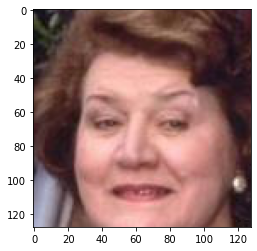

In [18]:
plt.imshow(images[0])

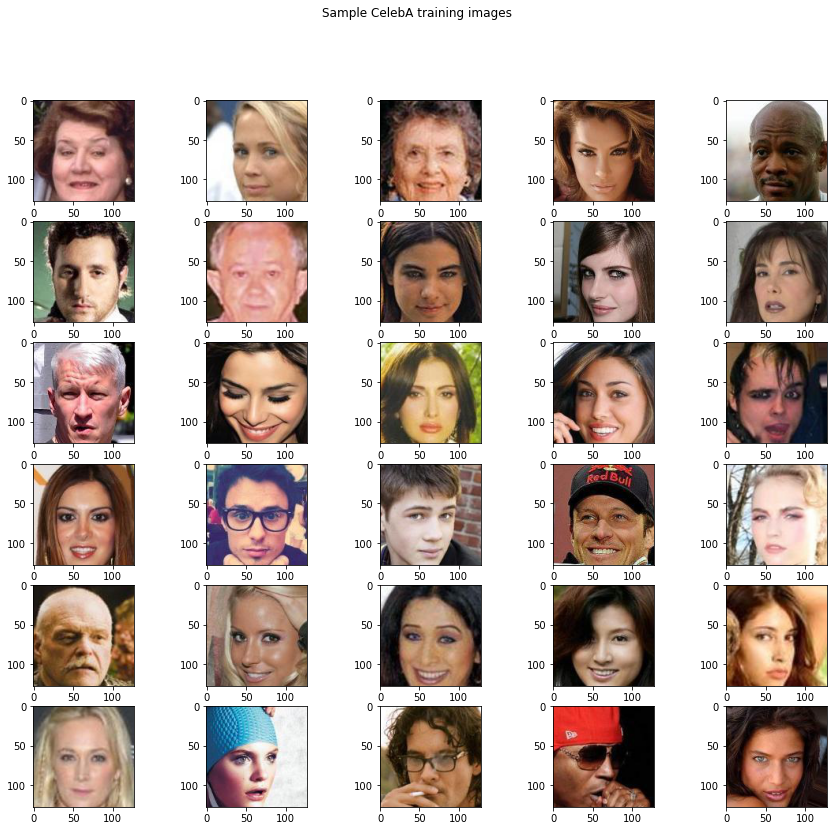

In [19]:
# Visualize 30 images from training set-
plt.figure(figsize = (15, 13))
for i in range(30):
    # 6 rows & 5 columns-
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CelebA training images")
plt.show()

In [20]:
del images, labels

### Define VAE architecture using _Convolutional_ layers

In [21]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


In [22]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]
    

In [23]:
class VAE_CelebA(nn.Module):
    def __init__(self, latent_space = 200):
        super(VAE_CelebA, self).__init__()
        
        self.latent_space = latent_space
        
        # Define encoder architecture-
        self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels = 3, out_channels = 32,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 32),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 32, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.Conv2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    bias = False, padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                nn.Flatten(),
        )    
        
        # Define mean & log-variance vectors to represent latent space 'z'-
        self.mu = torch.nn.Linear(in_features = 4096, out_features = self.latent_space)
        self.log_var = torch.nn.Linear(in_features = 4096, out_features = self.latent_space)
        
        # Define encoder architecture-
        self.decoder = nn.Sequential(
                torch.nn.Linear(
                    in_features = self.latent_space, out_features = 4096
                ),
                Reshape(-1, 64, 8, 8),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 64,
                    stride = 2, kernel_size = 3,
                    padding = 1
                ),
                nn.BatchNorm2d(num_features = 64),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 64, out_channels = 32,
                    stride = 2, kernel_size = 3,
                    padding = 1),
                nn.BatchNorm2d(num_features = 32),
                nn.LeakyReLU(0.1, inplace = True),
                nn.Dropout2d(p = 0.25),
                
                nn.ConvTranspose2d(
                    in_channels = 32, out_channels = 3,
                    stride = 2, kernel_size = 3,
                    padding = 1
                ),
                
                # Trim: 3x129x129 -> 3x128x128
                Trim(),
            
                # Due to input image being in the scale [0, 1], use sigmoid-
                nn.Sigmoid()
                )

        
    def reparameterize(self, mu, log_var):
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        # eps = torch.randn_like(log_var).to(log_var.get_device())
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(log_var / 2.0) 
        return z
    
    
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.mu(x), self.log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
        
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # Get mean & log-var vectors representing latent space distribution-
        mu, log_var = self.mu(x), self.log_var(x)
        
        # Obtain the latent vector 'z' using reparameterization-
        z = self.reparameterize(mu = mu, log_var = log_var)
        
        # Get reconstruction using 'z' as input to decoder-
        x_recon = self.decoder(z)
        
        return x_recon, mu, log_var
        
        
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu, log_var = self.mu(x), self.log_var(x)
        z = self.reparameterize(mu = mu, log_var = log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        
        x_recon = self.decoder(z)
        print(f"Decoder output shape: {x_recon.shape}")
        del x, x_recon, mu, log_var, z
        return None

    

In [24]:
# Initialize and load trained weights-
trained_model = VAE_CelebA(latent_space = 200).to(device)

In [25]:
trained_model.load_state_dict(torch.load("../Weights_and_Other_files/VAE_CelebA_last_epoch.pth"))

<All keys matched successfully>

In [26]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in trained_model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([32, 3, 3, 3]) has 864 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([64, 32, 3, 3]) has 18432 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([200, 4096]) has 819200 parameters
layer.shape = torch.Size([200]) has 200 parameters
layer.shape = torch.Size([200, 4096]) has 819200 parameters
layer.shape = torch.Size([200]) has 200 parameters
layer.shape = torch.Size([4096, 200]) has 819200 parameters
layer.shape = torch.Size([4096]) has 4096 parameters
layer.shape = torch.Size([64

In [27]:
print(f"Total number of parameters in VAE model = {tot_params}")

Total number of parameters in VAE model = 2649075


In [29]:
# Access modules/layers within defined VAE model-
for layer in trained_model.state_dict().keys():
    print(layer)

encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.4.weight
encoder.5.weight
encoder.5.bias
encoder.5.running_mean
encoder.5.running_var
encoder.5.num_batches_tracked
encoder.8.weight
encoder.9.weight
encoder.9.bias
encoder.9.running_mean
encoder.9.running_var
encoder.9.num_batches_tracked
encoder.12.weight
encoder.13.weight
encoder.13.bias
encoder.13.running_mean
encoder.13.running_var
encoder.13.num_batches_tracked
mu.weight
mu.bias
log_var.weight
log_var.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
decoder.3.weight
decoder.3.bias
decoder.3.running_mean
decoder.3.running_var
decoder.3.num_batches_tracked
decoder.6.weight
decoder.6.bias
decoder.7.weight
decoder.7.bias
decoder.7.running_mean
decoder.7.running_var
decoder.7.num_batches_tracked
decoder.10.weight
decoder.10.bias
decoder.11.weight
decoder.11.bias
decoder.11.running_mean
decoder.11.running_var
decoder.11.num_batches_trac

### Latent Space Arithmetic

1. Compute _smile vector_ ($z_s$): __Average latent space embeddings for all input images who are smiling__ by using the 40-d binary attributes in _CelebA_ dataset.
    1. Focus on all images where ```31 - Smiling``` is True.

1. Compute _no-smile vector_ - ($z_n$): Repeat the previous step for all input images where people are not smiling.

1. Compute difference vector: ($z_{diff} = z_s - z_n$) pointing from no smile to smile.

1. For a new input image, make it smile by: $z_{new} = z_{orig} + \alpha \times z_{diff}$)<br>
Here, $\alpha$ is a scaling hyper-parameter which determines how much smiling we want to have.


Here, 'z' is the encoded/embedding of the input image.

In [30]:
images, labels = next(iter(train_loader))

In [31]:
images.shape, labels.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 40]))

In [33]:
labels[0, :]

tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# Check whether the first image is smiling-
labels[0, 31]

tensor(1)

In [36]:
images = images.cpu().detach().numpy()

In [37]:
images = np.transpose(images, (0, 2, 3, 1))

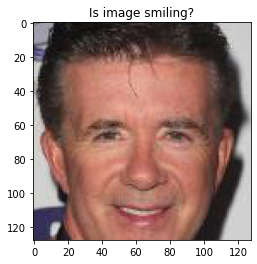

In [41]:
# Sanity check whether the first is indeed smiling?
plt.figure(figsize = (5, 4))
plt.imshow(images[0])
plt.title("Is image smiling?")
plt.show()

In [96]:
def compute_average_faces(feature_idx, image_dim, data_loader, device = None, encoding_fn = None):
    '''
    Function to compute average faces for a given attribute and without the given attribute.
    '''

    avg_img_with_feat = torch.zeros(image_dim, dtype = torch.float32).to(device)
    avg_img_without_feat = torch.zeros(image_dim, dtype = torch.float32).to(device)

    num_img_with_feat = 0
    num_images_without_feat = 0

    for images, labels in data_loader:
        # torch.bool converts from 0/1 to True/False-
        idx_img_with_feat = labels[:, feature_idx].to(torch.bool)
        # a vector containing True/False for smiling attribute.

        if encoding_fn is None:
            embeddings = images
        else:
            # Get latent representation 'z'-
            with torch.no_grad():

                if device is not None:
                    images = images.to(device)
                # embeddings = encoding_fn(images).to('cpu')
                embeddings = encoding_fn(images).to(device)    

        avg_img_with_feat += torch.sum(embeddings[idx_img_with_feat], axis = 0)
        avg_img_without_feat += torch.sum(embeddings[~idx_img_with_feat], axis = 0)
        num_img_with_feat += idx_img_with_feat.sum(axis = 0)
        num_images_without_feat += (~idx_img_with_feat).sum(axis = 0)

    avg_img_with_feat /= num_img_with_feat
    avg_img_without_feat /= num_images_without_feat
    
    return avg_img_with_feat, avg_img_without_feat


In [43]:
# For now, do not use any encoding-
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    # Smiling attribute index-
    feature_idx = 31,
    image_dim = (3, 128, 128), data_loader = train_loader,
    device = device, encoding_fn = None
)

In [45]:
avg_img_with_feat.shape, avg_img_without_feat.shape

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

In [50]:
avg_img_with_feat = avg_img_with_feat.cpu().detach().numpy()
avg_img_without_feat = avg_img_without_feat.cpu().detach().numpy()

In [ ]:
# labels[:, 31].to(torch.bool)
# labels[:, 31]

In [51]:
avg_img_with_feat = np.transpose(avg_img_with_feat, (1, 2, 0))
avg_img_without_feat = np.transpose(avg_img_without_feat, (1, 2, 0))

In [52]:
avg_img_with_feat.shape, avg_img_without_feat.shape

((128, 128, 3), (128, 128, 3))

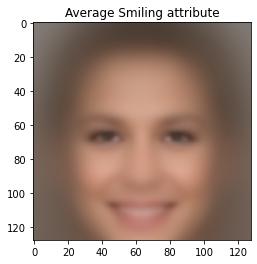

In [53]:
# Visualize average smiling attribute-
plt.figure(figsize = (5, 4))
plt.imshow(avg_img_with_feat)
plt.title("Average Smiling attribute")
plt.show()

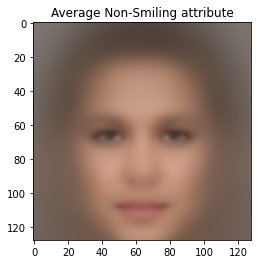

In [54]:
# Visualize average non-smiling attribute-
plt.figure(figsize = (5, 4))
plt.imshow(avg_img_without_feat)
plt.title("Average Non-Smiling attribute")
plt.show()

Given a new image, can we manipulate it to make it smile?

In [56]:
# Compute difference vector z_diff = z_smile - z_no_smile-
z_diff = avg_img_with_feat - avg_img_without_feat

In [57]:
z_diff.shape

(128, 128, 3)

In [121]:
def plot_modified_faces(
    original, diff,
    diff_coefficients = (0., 0.5, 1., 1.5, 2., 2.5, 3.),
    decoding_fn = None, device = None,
    figsize = (8, 3)):

    fig, axes = plt.subplots(
        nrows = 2, ncols = len(diff_coefficients), 
        sharex = True, sharey = True,
        figsize = (10, 5)
    )

    for i, alpha in enumerate(diff_coefficients):
        # print(f"i = {i}, alpha = {alpha}")
        more = (original + (alpha * diff))
        less = (original - (alpha * diff))
    
        if decoding_fn is not None:
            #Latent -> Original space
            with torch.no_grad():
                if device is not None:
                    more = more.to(device).unsqueeze(0)
                    less = less.to(device).unsqueeze(0)

                # Add more smiling attribute-
                # more = decoding_fn(more).to('cpu').squeeze(0)
                more = decoding_fn(more).to(device).squeeze(0)
                
                # Remove smiling attribute-
                # less = decoding_fn(less).to('cpu').squeeze(0)
                less = decoding_fn(less).to(device).squeeze(0)
    
        if not alpha:
            s = 'original'
        else:
            s = f'$\\alpha=${alpha}'
            
        axes[0][i].set_title(s)
        axes[0][i].imshow(more)
        axes[1][i].imshow(less)
        axes[1][i].axison = False
        axes[0][i].axison = False
    
    plt.suptitle("Contrast between: Adding more vs. Removing smiling attribute")
    
    return None
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


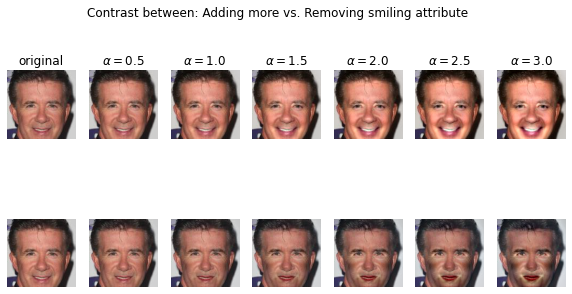

In [94]:
# Visualize: Adding vs. Removing smiling attribute-
plot_modified_faces(
    original = images[0], diff = z_diff,
    decoding_fn = None, device = device,
    figsize = (10, 2))
# Done in the original input space!

#### For original input space

- For adding more smile (top row), it seems to work well. Just by adding average smiling faces, we can make this work. This will not work although with all of the attributes.

- For removing smile (bottom row), it does not seem to work well.

But now, instead of manipulating the original input space, we try this manipulation in the latent space. For high resolution architecture, you can do _fun_ things by manipulating it's corresponding latent space.

#### Compute latent space encoding for _smiling_ & _not smiling_ attributes

In [97]:
# For now, do not use any encoding-
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    # Smiling attribute index-
    feature_idx = 31, image_dim = 200,
    data_loader = train_loader, device = device,
    encoding_fn = trained_model.encoding_fn
)

In [98]:
z_diff = (avg_img_with_feat - avg_img_without_feat)

In [106]:
images, labels = next(iter(train_loader))

In [107]:
images.shape, labels.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 40]))

In [108]:
img = images[0]

In [109]:
# By 'unsqueeze(0)' you add the batch_size dimension-
img = img.unsqueeze(0).to(device)

In [110]:
img.shape

torch.Size([1, 3, 128, 128])

In [114]:
with torch.no_grad():
    z = trained_model.encoding_fn(img).squeeze(0).to('cpu')

In [115]:
z.shape

torch.Size([200])

In [122]:
def plot_modified_faces(
    original, diff,
    diff_coefficients = (0., 0.5, 1., 1.5, 2., 2.5, 3.),
    decoding_fn = None, device = None,
    figsize = (8, 3)):

    fig, axes = plt.subplots(
        nrows = 2, ncols = len(diff_coefficients), 
        sharex = True, sharey = True,
        figsize = (10, 5)
    )
    
    original = original.to(device)
    diff = diff.to(device)

    for i, alpha in enumerate(diff_coefficients):
        # print(f"i = {i}, alpha = {alpha}")
        more = (original + (alpha * diff)).to(device)
        less = (original - (alpha * diff)).to(device)
    
        if decoding_fn is not None:
            #Latent -> Original space
            with torch.no_grad():
                if device is not None:
                    more = more.to(device).unsqueeze(0)
                    less = less.to(device).unsqueeze(0)

                # Add more smiling attribute-
                more = decoding_fn(more).to('cpu').squeeze(0)
                # more = decoding_fn(more).to(device).squeeze(0)
                
                # Remove smiling attribute-
                less = decoding_fn(less).to('cpu').squeeze(0)
                # less = decoding_fn(less).to(device).squeeze(0)
    
        if not alpha:
            s = 'original'
        else:
            s = f'$\\alpha=${alpha}'
            
        axes[0][i].set_title(s)
        axes[0][i].imshow(more.permute(1, 2, 0))
        axes[1][i].imshow(less.permute(1, 2, 0))
        axes[1][i].axison = False
        axes[0][i].axison = False
    
    plt.suptitle("Contrast between: Adding more vs. Removing smiling attribute")
    
    return None
        

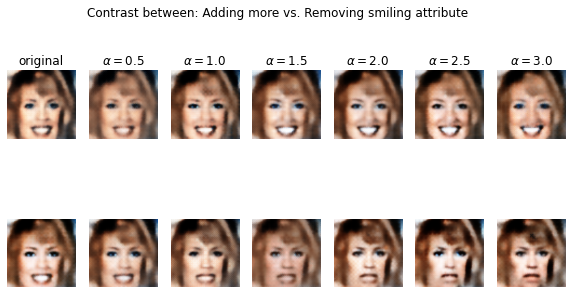

In [123]:
# Visualize: Adding vs. Removing smiling attribute-
plot_modified_faces(
    original = z, diff = z_diff,
    decoding_fn = trained_model.decoder,
    device = device,
    figsize = (10, 2))
# Done in latent space!
# alpha - controls magnitude of smiling attribute

Control the smile attribute by manipulating the latent space.

- In the top row, you add more smile

- In the bottom row, you remove smile

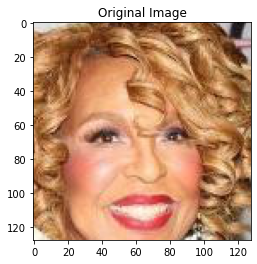

In [137]:
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.title("Original Image")
plt.show()